# Chapter 11 - I2VIS

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

In [2]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf

include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

using PyPlot

In [3]:
# Define a function to form the energy equation left hand side and right hand side
function assemble_energy_equation_center(grid::CartesianGrid,rho::Matrix,Cp::Matrix,kThermal::Matrix,H::Matrix,Tlast::Matrix,dt)
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    
    N = grid.nx*grid.ny
    row = zeros(Int64,5*N);
    col = zeros(Int64,5*N);
    val = zeros(Float64, 5*N);
    R = zeros(Float64,N,1);
    k = 1;
    #        j-1   j     j   j+1   j+1
    #   i-1   |----kC----|----vy----|
    #         |          |          |
    #   i     kA    T   kB    T     |
    #         |          |          |
    #   i     |----kD--(i,j)--vy----|
    #         |          |          |
    #   i+1   vx    c    vx   c     vx
    #         |          |          |
    #   i+1   |----vy----|----vy----|
    
    for j in 1:grid.nx
        dxc = j>1 ? grid.x[j] - grid.x[j-1] : grid.x[j+1] - grid.x[j]
        dxp = grid.xc[j+1] - grid.xc[j]
        dxm = j>1 ? grid.xc[j]-grid.xc[j-1] : grid.xc[j+1] - grid.xc[j]
        for i in 1:grid.ny
            dyc = i>1 ? grid.y[i] - grid.y[i-1] : grid.y[i+1] - grid.y[i]
            dyp = grid.yc[i+1] - grid.yc[i]
            dym = i>1 ? grid.yc[i]-grid.yc[i-1] : grid.yc[i+1] - grid.yc[i]
            
            this_row = node_index(i,j,grid.ny);
            if i==1 # ghost nodes along top.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i+1,j,grid.ny)
                val[k] = bctop/2.0
                k+=1
                
                R[this_row] = bcval[3]
            elseif j==1 # ghost nodes along left side.
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0/2.0
                k+=1
                
                row[k] = this_row
                col[k] = node_index(i,j+1,grid.ny)
                val[k] = bcleft/2.0
                k+=1
                
                R[this_row] = bcval[1]
            else            
                # kA, kB, kC, kD
                kA = 0.5*(kThermal[i-1,j-1] + kThermal[i,j-1])
                kB = 0.5*(kThermal[i,j]     + kThermal[i-1,j])
                kC = 0.5*(kThermal[i-1,j-1] + kThermal[i-1,j])
                kD = 0.5*(kThermal[i,j-1]   + kThermal[i,j])
                rho_c = 0.25*(rho[i-1,j-1] + rho[i,j-1] + rho[i-1,j] + rho[i,j])
                Cp_c = 0.25*(Cp[i-1,j-1] + Cp[i,j-1] + Cp[i-1,j] + Cp[i,j])

                # diagonal entry
                row[k] = this_row;
                col[k] = this_row;
                val[k] = (rho_c*Cp_c)/dt + kB/dxp/dxc + kA/dxm/dxc + kD/dyp/dyc + kC/dyp/dyc;
                k+=1
                # right
                row[k] = this_row;
                #col[k] = j==grid.nx ? node_index(i,2,grid.ny) : node_index(i,j+1,grid.ny);
                col[k] = j==grid.nx ? node_index(i,j,grid.ny) : node_index(i,j+1,grid.ny);
                val[k] = j==grid.nx ? bcright*kB/dxp/dxc : -kB/dxp/dxc;
                k+=1
                # left
                row[k] = this_row;
                col[k] = node_index(i,j-1,grid.ny);
                val[k] = -kA/dxm/dxc;
                k+=1
                # down (+y)
                row[k] = this_row;
                col[k] = i==grid.ny ? node_index(i,j,grid.ny) : node_index(i+1,j,grid.ny);
                val[k] = i==grid.ny ? bcbottom*kD/dyp/dyc : -kD/dyp/dyc;
                k+=1
                # up (-y)
                row[k] = this_row;
                col[k] = node_index(i-1,j,grid.ny);
                val[k] = -kC/dyp/dyc;
                k+=1
                
                R[this_row] = Tlast[i,j]*rho_c*Cp_c/dt;
                if j==grid.nx
                    R[this_row] += 2*bcval[2]*bcright*kB/dxp/dxc
                end
                if i==grid.ny
                    R[this_row] += 2*bcval[4]*bcbottom*kD/dyp/dyc
                end
            end
        end
    end
    row = @views row[1:k-1]
    col = @views col[1:k-1]
    val = @views val[1:k-1]
    L = sparse(row,col,val)
    return L,R
end

function ghost_temperature(grid::CartesianGrid,T::Matrix)
    # Define a new grid that is (ny+1)x(nx+1) and insert the ghost temperature values.
    bcleft  = -1   # -1 = insulating, 1 = constant temp
    bcright = -1   #
    bctop   =  1
    bcbottom  = 1
    bcval = [0.0,0.0,1000.0,1000.0] # left,right,top,bottom
    Tpad = Array{Float64,2}(undef,grid.ny+1,grid.nx+1)
    Tpad[1:grid.ny,1:grid.nx] = T[1:grid.ny,1:grid.nx]
    # right side first
    for i in 1:grid.ny
        if bcright == 1
             Tpad[i,grid.nx+1] = 2.0*bcval[2]-Tpad[i,grid.nx]
        elseif bcright == -1
            Tpad[i,grid.nx+1] = Tpad[i,grid.nx]
        end
    end
    # bottom
    for j in 1:grid.nx+1
        if bcbottom == 1
            Tpad[grid.ny+1,j] = 2.0*bcval[4]-Tpad[grid.ny,j]
        elseif bcbottom == -1
            Tpad[grid.ny+1,j] = Tpad[grid.ny,j]
        end
    end
    return Tpad
end

function subgrid_temperature_relaxation!(markers::Markers,grid::CartesianGrid,Tlast::Matrix,Cp,kThermal,dt::Float64)
        dsubgrid = 1.0; # subgrid temperature diffusivity
        dT_subgrid_m = Array{Float64,1}(undef,markers.nmark)
        # compuate the nodal temperature on the markers.
    
        cell_center_to_markers!(markers,grid,Tlast,dT_subgrid_m)
#         figure()
#         scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=dT_subgrid_m)
#         title("Tlast at markers")
#         colorbar()
#         show()
    
        # compute the subgrid temperature changes on the markers
        rho = markers.scalarFields["rho"]
        T = markers.scalarFields["T"]
        Threads.@threads for i in 1:markers.nmark
            dx2 = (grid.x[markers.cell[1,i]+1] - grid.x[markers.cell[1,i]])^2
            dy2 = (grid.y[markers.cell[2,i]+1] - grid.y[markers.cell[2,i]])^2
            tdiff = markers.scalars[rho,i]*Cp/kThermal / (2/dx2 + 2/dy2)
            dT_subgrid_m[i] = (dT_subgrid_m[i]-markers.scalars[T,i])*( 1.0 - exp(-dsubgrid*dt/tdiff) )
        end
        # interpolate subgrid temperature changes back onto basic nodes.
        markers.scalars[T,1:markers.nmark] += dT_subgrid_m
    
        dT_subgrid_node = marker_to_cell_center(markers,grid,dT_subgrid_m)
#         figure()
#         pcolormesh(dT_subgrid_node)
#         title("subgrid change at nodes")
#         colorbar()
#         show()
        return dT_subgrid_node
end

function initial_conditions!(markers::Markers)
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.scalars[rho,i] = mr < 1.0e5 ? 3200. : 3300.
        markers.scalars[eta,i] = mr < 1.0e5 ? 1e20 : 1e21 
        markers.scalars[T,i] = mr < 1.0e5 ? 1300. : 1000.
    end
end

function visualization(grid::CartesianGrid,rho::Matrix,eta::Matrix,vn::Array{Float64},pressure::Matrix,temperature::Matrix,time ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    vtk_grid(filename, grid.x, grid.y) do vtk
        vtk["rho"] = transpose(rho)
        vtk["viscosity"] = transpose(eta)
        # add a fake third dimension to the velocity vectors
        v3 = Array{Float64,3}(undef,3,grid.nx,grid.ny)
        v3[1:2,:,:] = vn
        v3[3,:,:] .= 0.0
        vtk["Velocity"] = v3
        vtk["Temperature"] = transpose(temperature)
        vtk["pressure"] = transpose(pressure[2:end,2:end])
        vtk["TIME"] = time
    end
end

function visualization(markers::Markers,time; filename="markers.vtp")  
    p3 = Array{Float64,2}(undef,3,markers.nmark)
    p3[1:2,:] = markers.x[1:2,1:markers.nmark]
    p3[3,:] .= 0.0
      
    polys = [MeshCell(PolyData.Polys(),i:i) for i in 1:markers.nmark]
    vtk_grid(filename,p3,polys) do vtk    
        for key in keys(markers.scalarFields)
            vtk[key] = markers.scalars[markers.scalarFields[key],1:markers.nmark]
        end
       vtk["TIME"] = time
    end
end

visualization (generic function with 2 methods)

In [4]:
nx = 501
ny = 501
W = 5e5
H = 5e5
gx = 0.0
gy = 10.0

bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.


markx = 5
marky = 5
seconds_in_year = 3.15e7
plot_interval = 1e5*seconds_in_year # plot interval in seconds
end_time = 3e7*seconds_in_year
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
println("Initial condition...")
@time initial_conditions!(markers)

# define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
kThermal = 3.0 .*ones(grid.ny,grid.nx);
Cp = 1250. .* ones(grid.ny,grid.nx);
H = zeros(grid.ny,grid.nx);
# fill!(rho,3200.);
# fill!(kThermal,3.0);
# fill!(Cp,1000.);

time = 0.0
iout=0
# while time <= end_time
    # Get density and viscosity from the markers.
    tmp = marker_to_basic_node(markers,grid,["rho","eta"]);
    rho_new = tmp[1,:,:];
    eta_s_new = tmp[2,:,:];
    
    if time > 0.0
        nanind = findall(isnan.(rho_new))
        rho_new[nanind] = rho[nanind]
        eta_s_new[nanind] = eta_s[nanind]     
    end
    
    global rho   = copy(rho_new)
    global eta_s = copy(eta_s_new) 
    
    eta_n = viscosity_to_cell_centers(grid,eta_s_new)

    # assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    
    # get temperature at cell centers
    tmp = marker_to_cell_center(markers,grid,["T",])
    Tlast = tmp[1,:,:]
    Tlast = ghost_temperature(grid,Tlast);

    # assemble and solve the energy equation
    L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
    Tnew = L\R;
    Tnew = reshape(Tnew,grid.ny,grid.nx);
    Tnew = ghost_temperature(grid,Tnew);
    
    dTemp = Tnew-Tlast
    dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
    if time == 0.0 || time - last_plot >= plot_interval
        last_plot = time 
        name = @sprintf("output_chapter11/viz.%04d.vtr",iout)
        eta_s = zeros(grid.ny,grid.nx)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew,time/seconds_in_year;filename=name)
        name = @sprintf("output_chapter11/markers.%04d.vtp",iout)
        visualization(markers,time/seconds_in_year;filename=name)
        iout += 1
    end
    
    move_markers_rk2!(markers,grid,vxc,vyc,dt)
    time += dt
# end

SystemError: SystemError: opening file "output_chapter11/viz.0000.vtr": No such file or directory

In [7]:
print(Threads.nthreads())

1

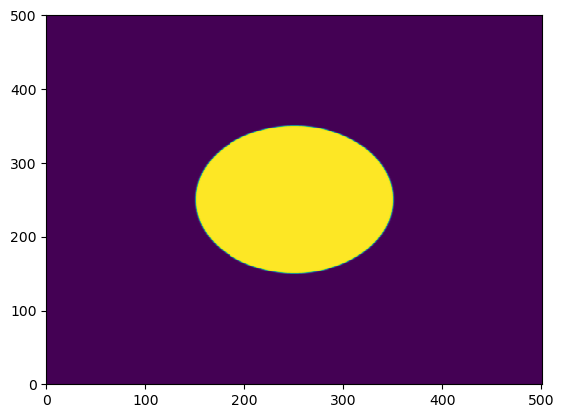

Vector{Float64} 12.686225 seconds (238.18 M allocations: 6.246 GiB, 9.54% gc time, 4.34% compilation time)
(501, 501)

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/max/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [6]:
print(typeof( markers.scalars[1,:]) )
@time tmp = marker_to_basic_node2(markers,grid,markers.scalars[1,:])
print(size(tmp))
figure()
pcolormesh(tmp)
display(gcf())

Creating Markers...
Initial condition...
  0.000185 seconds


10000

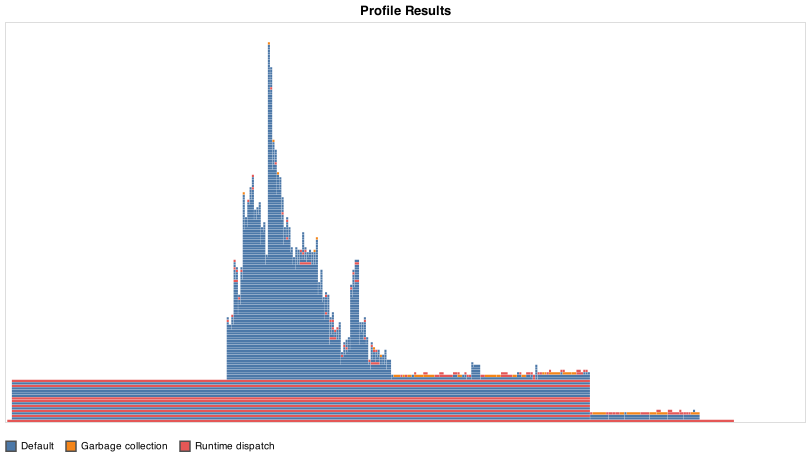

In [22]:
function single_timestep(ny,nx)
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);

    time = 0.0
    iout=0
    # Get density and viscosity from the markers.
    tmp = marker_to_basic_node(markers,grid,["rho","eta"]);
    rho_new = tmp[1,:,:];
    eta_s_new = tmp[2,:,:];
    
    if time > 0.0
        nanind = findall(isnan.(rho_new))
        rho_new[nanind] = rho[nanind]
        eta_s_new[nanind] = eta_s[nanind]     
    end
    
    global rho   = copy(rho_new)
    global eta_s = copy(eta_s_new) 
    
    eta_n = viscosity_to_cell_centers(grid,eta_s_new)

    # assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    
    # get temperature at cell centers
    tmp = marker_to_cell_center(markers,grid,["T",])
    Tlast = tmp[1,:,:]
    Tlast = ghost_temperature(grid,Tlast);

    # assemble and solve the energy equation
    L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt);
    Tnew = L\R;
    Tnew = reshape(Tnew,grid.ny,grid.nx);
    Tnew = ghost_temperature(grid,Tnew);
    
    dTemp = Tnew-Tlast
    dT_subgrid_node = subgrid_temperature_relaxation!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node
    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
    # if time == 0.0 || time - last_plot >= plot_interval
    #     last_plot = time 
    #     name = @sprintf("output_chapter11/viz.%04d.vtr",iout)
    #     eta_s = zeros(grid.ny,grid.nx)
    #     vn = velocity_to_basic_nodes(grid,vxc,vyc)

    #     visualization(grid,rho,eta_s,vn,P,Tnew,time/seconds_in_year;filename=name)
    #     name = @sprintf("output_chapter11/markers.%04d.vtp",iout)
    #     visualization(markers,time/seconds_in_year;filename=name)
    #     iout += 1
    # end
    print(markers.nmark)
    move_markers_rk2!(markers,grid,vxc,vyc,dt)
    time += dt
end

using ProfileVega
ProfileVega.@profview single_timestep(21,21)